# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import itemfreq, chisquare
# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';') 

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';') 

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
# azdias data has shape (891221, 85)
print(azdias.shape)
print(azdias.info())

(891221, 85)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB     

In [4]:
# check first two rows
print(azdias.head(2))

   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...            NaN         NaN   
1                      4                 5    ...            2.0         3.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         NaN         NaN          NaN       NaN       NaN     NaN   
1         2.0         1.0          1.0       5.0       4.0     3.0   

   ORTSGR_KLS9  RELAT_AB  
0          NaN       NaN  
1          5.0       4.0  

[2 rows x 85 columns]


In [5]:
# check null number for each col
print(azdias.isnull().sum())

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [6]:
# check feat_info data
print(feat_info.head(5))

              attribute information_level         type missing_or_unknown
0              AGER_TYP            person  categorical             [-1,0]
1  ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2             ANREDE_KZ            person  categorical             [-1,0]
3         CJT_GESAMTTYP            person  categorical                [0]
4     FINANZ_MINIMALIST            person      ordinal               [-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
# Identify missing or unknown data values and convert them to NaNs.
# check unique values
# notice dtype is object
feat_info.missing_or_unknown.unique()

array(['[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]',
       '[XX]', '[-1,XX]'], dtype=object)

In [8]:
# function to convert feat_info.missing_or_unknown into list type
def object_to_list(s):
    if s=='[-1,X]':
        return [-1,'X']
    elif s=='[XX]':
        return ['XX']
    elif s=='[-1,XX]':
        return [-1,'XX']
    else:
        return eval(s)

In [9]:
# convert value type for feat_info.missing_or_unknown
feat_info.missing_or_unknown = feat_info.missing_or_unknown.apply(object_to_list)

In [10]:
# Create a dictionary to map column names to missing data encodings
missing_data_encode = dict(zip(feat_info.attribute, feat_info.missing_or_unknown))

In [11]:
# Convert to nans using the missing_data_encode dictionary
# refer to this blog https://jkarakas.github.io/Customer-Demographics-Segmentation-/Customer_Segmentation.html
dem_df = azdias.copy()
for col in missing_data_encode.keys():
    print(col)
    nans_before = dem_df[col].isnull().sum()
    # get missing value for the current col
    missing_values = missing_data_encode[col]
    # current col values
    col_values = dem_df[col]
    # get row index for missing values in col
    missing_values_ridx = col_values.isin(missing_values)
    # set missing values to nan
    dem_df.loc[missing_values_ridx, col] = np.nan
    nans_after = dem_df[col].isnull().sum()
    if nans_after != nans_before:
        print(col, 'nans before: ', nans_before)
        print(col, 'nans after: ', nans_after, '\n')

AGER_TYP
AGER_TYP nans before:  0
AGER_TYP nans after:  685843 

ALTERSKATEGORIE_GROB
ALTERSKATEGORIE_GROB nans before:  0
ALTERSKATEGORIE_GROB nans after:  2881 

ANREDE_KZ
CJT_GESAMTTYP
FINANZ_MINIMALIST
FINANZ_SPARER
FINANZ_VORSORGER
FINANZ_ANLEGER
FINANZ_UNAUFFAELLIGER
FINANZ_HAUSBAUER
FINANZTYP
GEBURTSJAHR
GEBURTSJAHR nans before:  0
GEBURTSJAHR nans after:  392318 

GFK_URLAUBERTYP
GREEN_AVANTGARDE
HEALTH_TYP
HEALTH_TYP nans before:  0
HEALTH_TYP nans after:  111196 

LP_LEBENSPHASE_FEIN
LP_LEBENSPHASE_FEIN nans before:  4854
LP_LEBENSPHASE_FEIN nans after:  97632 

LP_LEBENSPHASE_GROB
LP_LEBENSPHASE_GROB nans before:  4854
LP_LEBENSPHASE_GROB nans after:  94572 

LP_FAMILIE_FEIN
LP_FAMILIE_FEIN nans before:  4854
LP_FAMILIE_FEIN nans after:  77792 

LP_FAMILIE_GROB
LP_FAMILIE_GROB nans before:  4854
LP_FAMILIE_GROB nans after:  77792 

LP_STATUS_FEIN
LP_STATUS_GROB
NATIONALITAET_KZ
NATIONALITAET_KZ nans before:  0
NATIONALITAET_KZ nans after:  108315 

PRAEGENDE_JUGENDJAHRE
PRAE

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [12]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
col_miss_num = dem_df.isnull().sum()
col_miss_per = (dem_df.isnull().mean())
print(col_miss_num.describe())
print(col_miss_per.describe())

count        85.000000
mean      98516.811765
std      146604.203317
min           0.000000
25%           0.000000
50%       93148.000000
75%      116515.000000
max      889061.000000
dtype: float64
count    85.000000
mean      0.110541
std       0.164498
min       0.000000
25%       0.000000
50%       0.104517
75%       0.130736
max       0.997576
dtype: float64


In [13]:
# Investigate patterns in the amount of missing data in each column.
col_miss_per = col_miss_per.to_frame()
col_miss_per.reset_index(level=0, inplace=True)
col_miss_per.columns = ['colname','misspre']
col_miss_per['information_level'] = feat_info.information_level
col_miss_per['type'] = feat_info.type
col_miss_per.head(2)

,colname,misspre,information_level,type
0,AGER_TYP,0.769554,person,categorical
1,ALTERSKATEGORIE_GROB,0.003233,person,ordinal


(array([ 39.,  40.,   0.,   1.,   1.,   1.,   1.,   1.,   0.,   1.]),
 array([ 0.        ,  0.09975764,  0.19951527,  0.29927291,  0.39903054,
         0.49878818,  0.59854582,  0.69830345,  0.79806109,  0.89781872,
         0.99757636]),
 <a list of 10 Patch objects>)

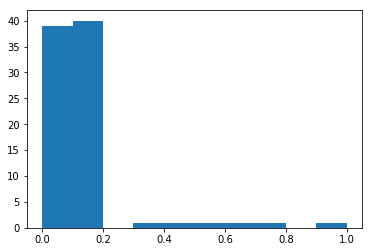

In [14]:
# plot histgram to visualize distribution of missing rate
plt.hist(col_miss_per.misspre)
# according to both this historgram and the descriptive statistics above we can see that most missing rate are lower than 20%
# so we should drop colunms that have missing rate larger than 20%

In [69]:
# explore pattern by group
print(col_miss_per.head(2))
print(col_miss_per.groupby('information_level').misspre.agg({"mean" : "mean","max":"max"}))
print(col_miss_per.groupby('type').misspre.agg({"mean" : "mean","max":"max"}))

                colname   misspre information_level         type
0              AGER_TYP  0.769554            person  categorical
1  ALTERSKATEGORIE_GROB  0.003233            person      ordinal
                       mean       max
information_level                    
building           0.103098  0.111769
community          0.109222  0.109260
household          0.205450  0.655967
macrocell_plz8     0.129234  0.130736
microcell_rr3      0.213779  0.534687
microcell_rr4      0.111479  0.111479
person             0.077389  0.997576
postcode           0.105182  0.105182
region_rr1         0.122856  0.177357
                 mean       max
type                           
categorical  0.166904  0.997576
interval     0.348137  0.348137
mixed        0.174064  0.534687
numeric      0.149856  0.440203
ordinal      0.066846  0.177357


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.


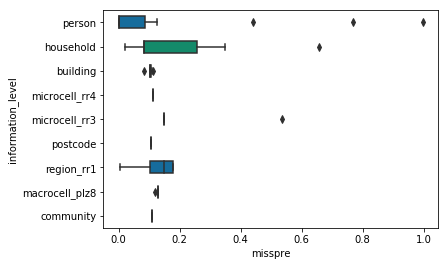

In [15]:
# draw boxplot 
#col_miss_per.boxplot(by='information_level', column=['misspre'], grid=False)
sns.boxplot(y='information_level', x='misspre', data=col_miss_per, 
            width=0.5,palette="colorblind")

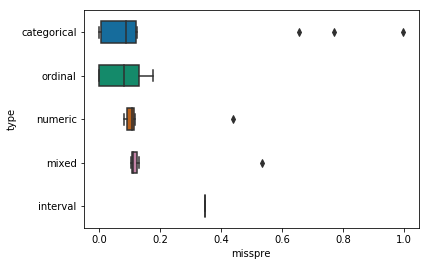

In [16]:
sns.boxplot(y='type', x='misspre', data=col_miss_per, 
            width=0.5,palette="colorblind")

In [17]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
# find colnames that have high missing rate
cols_remove = col_miss_per[col_miss_per.misspre > 0.2].colname            
cols_remove


0         AGER_TYP
11     GEBURTSJAHR
40        TITEL_KZ
43        ALTER_HH
47    KK_KUNDENTYP
64    KBA05_BAUMAX
Name: colname, dtype: object

In [18]:
dem_df = dem_df.drop(cols_remove, axis=1)
dem_df.shape

(891221, 79)

(array([ 31.,   1.,   0.,   0.,   7.,   9.,  12.,  10.,   6.,   3.]),
 array([ 0.        ,  0.01773567,  0.03547134,  0.053207  ,  0.07094267,
         0.08867834,  0.10641401,  0.12414968,  0.14188535,  0.15962101,
         0.17735668]),
 <a list of 10 Patch objects>)

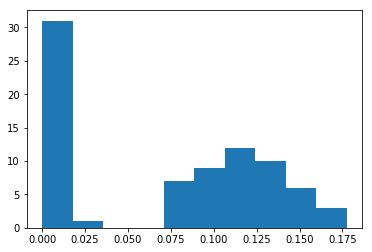

In [19]:
# check histgram again
col_miss_per_after = (dem_df.isnull().sum()/891221)
col_miss_per_after = col_miss_per_after.to_frame()
col_miss_per_after.reset_index(level=0, inplace=True)
col_miss_per_after.columns = ['colname','misspre']
col_miss_per_after['information_level'] = feat_info.information_level
col_miss_per_after['type'] = feat_info.type
plt.hist(col_miss_per_after.misspre)

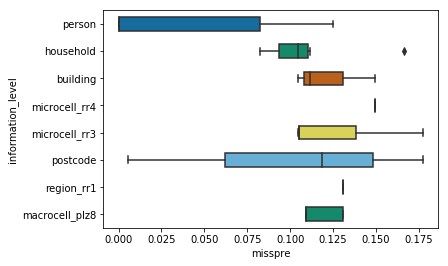

In [20]:
sns.boxplot(y='information_level', x='misspre', data=col_miss_per_after, 
            width=0.5,palette="colorblind")

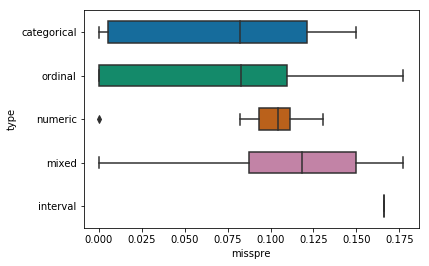

In [21]:
sns.boxplot(y='type', x='misspre', data=col_miss_per_after, 
            width=0.5,palette="colorblind")

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

According to descriptive statistics:
1)there are on average 11.05% missing rate across colunms
2)75% colunms has missing rate less than 13.07%

According to boxplot of information level
3)information level person tend to have higher unusual missing rates

According to boxplot of type
4)categorical type data tend to have higher unusual missing rates

The colunms that are removed are those with missing rate higher than 20% :AGER_TYP,GEBURTSJAHR,TITEL_KZ,ALTER_HH,KK_KUNDENTYP,KBA05_BAUMAX



#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

count    891221.000000
mean          0.071518
std           0.167528
min           0.000000
25%           0.000000
50%           0.000000
75%           0.037975
max           0.620253
Name: row_miss_per, dtype: float64


(array([  6.38947000e+05,   4.55550000e+04,   1.26070000e+04,
          3.62860000e+04,   3.83060000e+04,   3.04200000e+03,
          6.53700000e+03,   4.02100000e+03,   2.24300000e+03,
          7.24800000e+03,   6.77000000e+02,   1.60800000e+03,
          4.99000000e+02,   1.29000000e+02,   2.01000000e+02,
          1.14000000e+02,   2.40000000e+01,   1.70000000e+01,
          9.00000000e+00,   2.06000000e+02,   1.38010000e+04,
          3.91100000e+03,   6.22000000e+02,   4.98000000e+02,
          1.37000000e+02,   3.77000000e+02,   2.75240000e+04,
          4.94000000e+02,   4.55780000e+04,   3.00000000e+00]),
 array([ 0.        ,  0.02067511,  0.04135021,  0.06202532,  0.08270042,
         0.10337553,  0.12405063,  0.14472574,  0.16540084,  0.18607595,
         0.20675105,  0.22742616,  0.24810127,  0.26877637,  0.28945148,
         0.31012658,  0.33080169,  0.35147679,  0.3721519 ,  0.392827  ,
         0.41350211,  0.43417722,  0.45485232,  0.47552743,  0.49620253,
         0.51

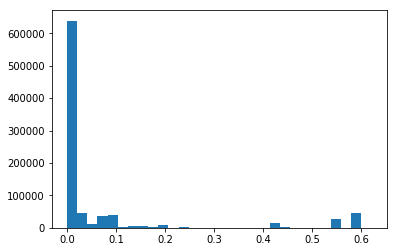

In [22]:
# How much data is missing in each row of the dataset?
dem_df['row_miss_per'] = dem_df.isnull().mean(axis=1)
print(dem_df.row_miss_per.describe())
plt.hist(dem_df.row_miss_per, bins=30)


In [23]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
threshhold = 0.1

dem_df_lowna = dem_df.loc[dem_df['row_miss_per'] < threshhold]
dem_df_highna = dem_df.loc[dem_df['row_miss_per'] > threshhold]
print(dem_df_lowna.shape)
print(dem_df_highna.shape)

(747109, 80)
(144112, 80)


In [24]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# find five columns that have no missing values for both data set
common_col = ((dem_df_lowna.isnull().sum() == 0)&(dem_df_highna.isnull().sum() == 0))
common_col = list(common_col[common_col == True].index)
print(common_col)
print(len(common_col))

['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GREEN_AVANTGARDE', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'ZABEOTYP', 'row_miss_per']
25


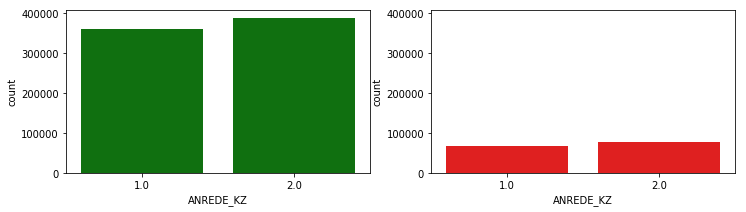

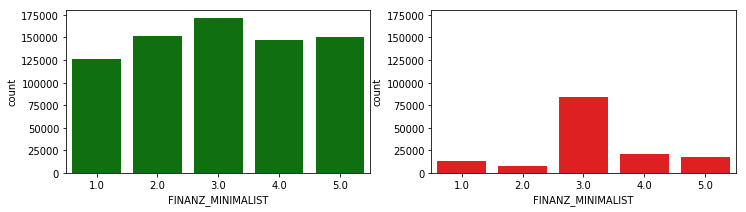

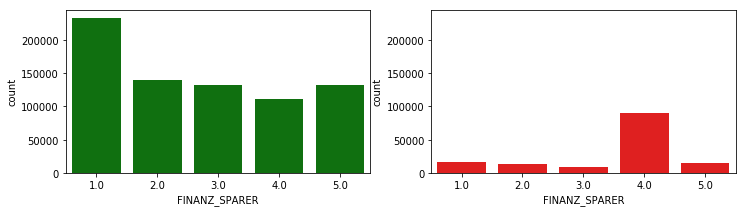

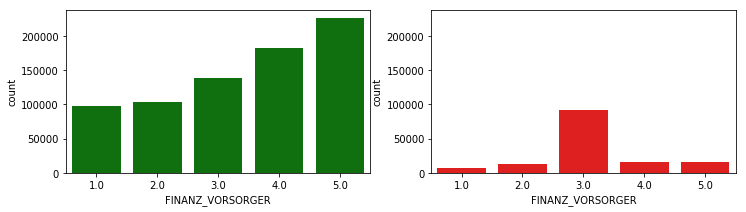

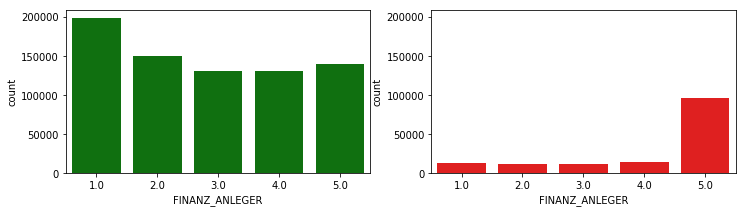

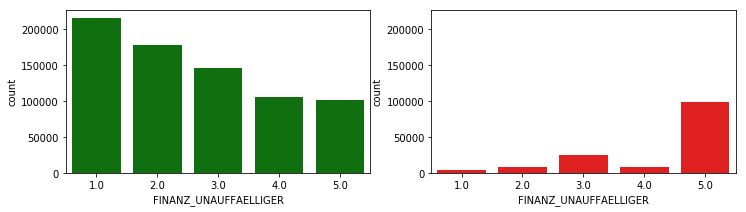

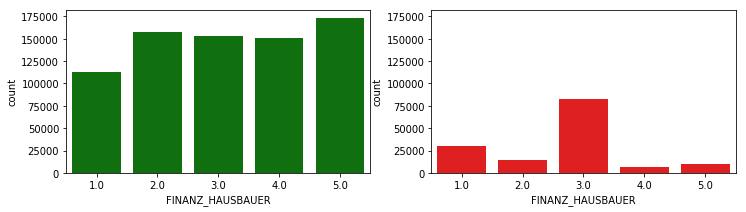

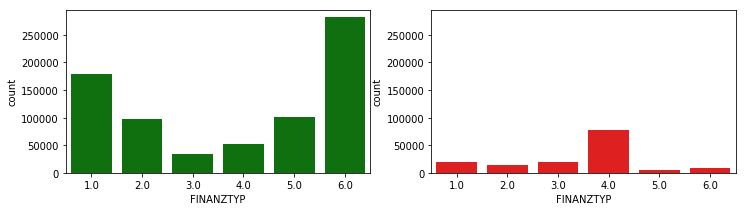

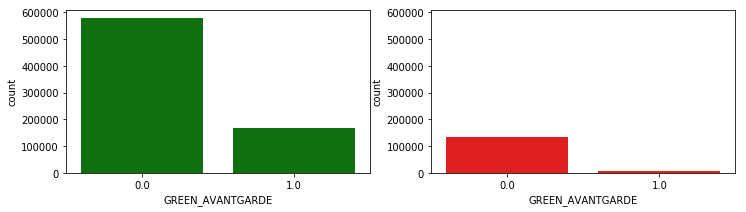

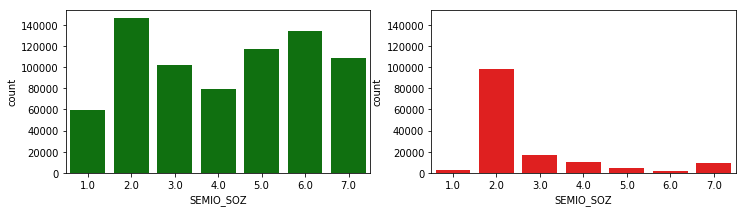

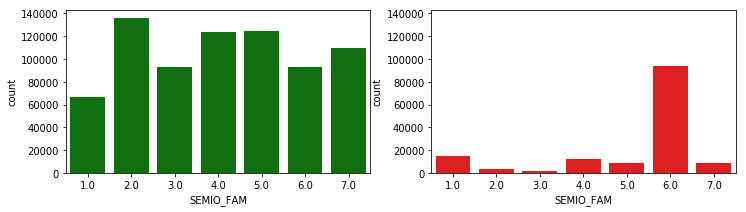

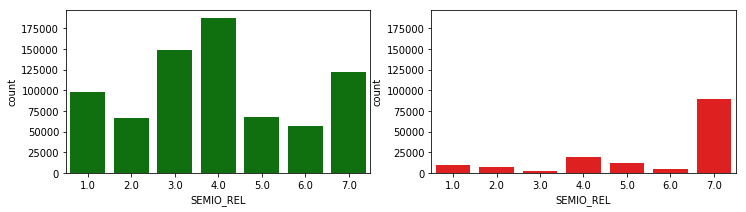

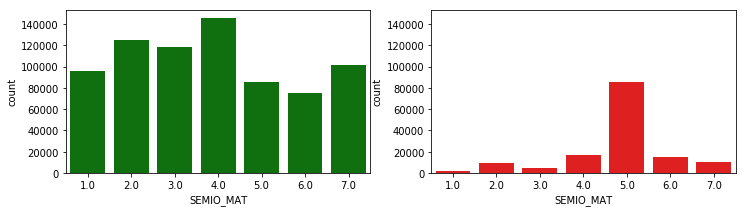

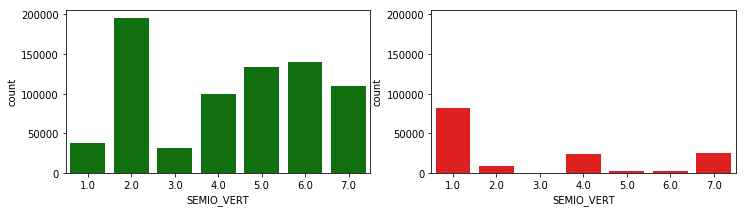

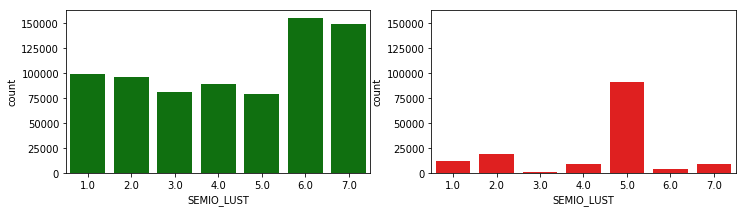

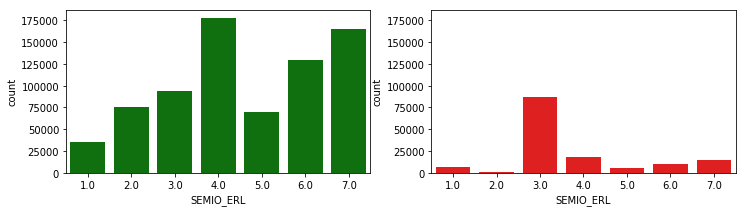

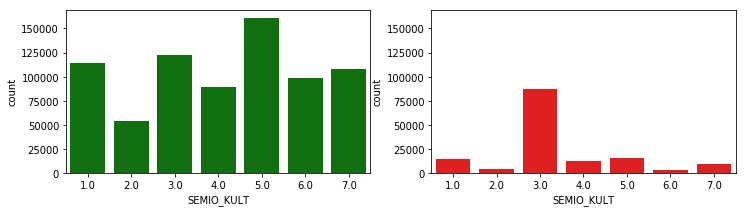

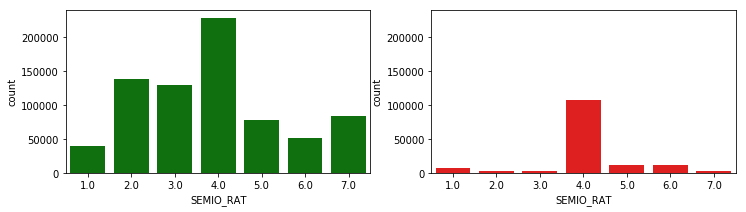

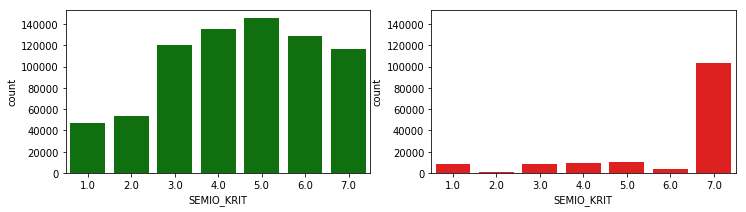

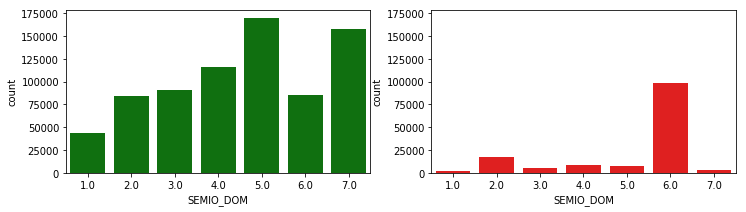

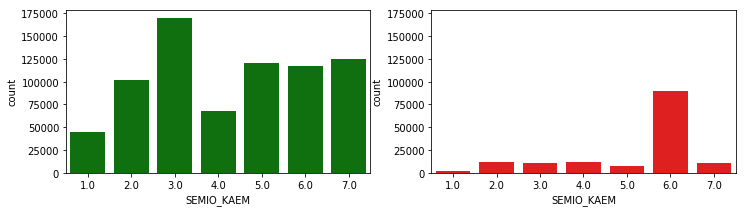

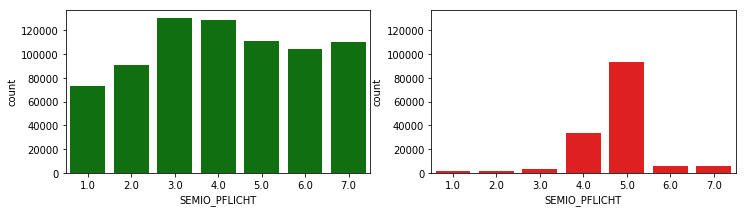

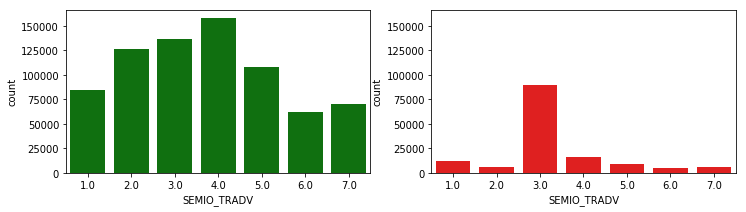

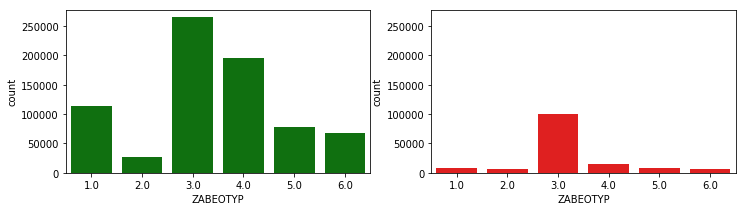

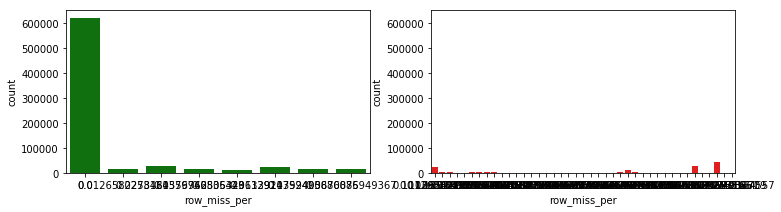

In [25]:
# draw count plot to compare between two groups
def draw_compare(colname,dem_df_lowna,dem_df_highna):
    fig, axes = plt.subplots(1,2, figsize=(12, 3))
    ax1 = plt.subplot(1,2,1)
    ax1 = sns.countplot(dem_df_lowna[colname],color='g')
    ax2 = plt.subplot(1,2,2,sharey=ax1)
    ax2 = sns.countplot(dem_df_highna[colname],color='r')
    plt.show()
    
for col in common_col:
    draw_compare(col,dem_df_lowna,dem_df_highna)

In [26]:
# keep only the rows with low missing rate
dem_df = dem_df_lowna
# drop row missing rate colunm
dem_df = dem_df.drop('row_miss_per', axis=1)
print(dem_df.shape)

(747109, 79)


#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)
Yes, they are quite different in all colunms. The high missing value data should be remarked as special

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [27]:
# How many features are there of each data type?
# drop the dropped colunms
feat_info = feat_info[feat_info.attribute.isin(dem_df.columns)]
# group by type and count
feat_info.groupby('type').attribute.count()
# so there are 18 colunms that belong to categorical and 6 belong to mixed


type
categorical    18
mixed           6
numeric         6
ordinal        49
Name: attribute, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [28]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
col_cate_num = dem_df[feat_info[feat_info.type=='categorical'].attribute].nunique().sort_values()
col_cate_num = col_cate_num.to_frame()
col_cate_num.reset_index(level=0, inplace=True)
col_cate_num.columns = ['colname','uniquen']
col_cate_num['type'] = list(dem_df[list(col_cate_num.colname)].dtypes)
print(col_cate_num)
# there are five columns that are binary and colunms 'OST_WEST_KZ' is of type object need to change that one.

             colname  uniquen     type
0          ANREDE_KZ        2  float64
1        OST_WEST_KZ        2   object
2           VERS_TYP        2  float64
3            SOHO_KZ        2  float64
4   GREEN_AVANTGARDE        2  float64
5   NATIONALITAET_KZ        3  float64
6        SHOPPER_TYP        4  float64
7     LP_STATUS_GROB        5  float64
8    LP_FAMILIE_GROB        5  float64
9          FINANZTYP        6  float64
10          ZABEOTYP        6  float64
11     CJT_GESAMTTYP        6  float64
12       GEBAEUDETYP        7  float64
13   CAMEO_DEUG_2015        9   object
14    LP_STATUS_FEIN       10  float64
15   LP_FAMILIE_FEIN       11  float64
16   GFK_URLAUBERTYP       12  float64
17    CAMEO_DEU_2015       44   object


In [29]:
# check OST_WEST_KZ value
dem_df['OST_WEST_KZ'].unique()

array(['W', 'O'], dtype=object)

In [30]:
# Re-encode categorical variable(s) to be kept in the analysis.
# re-encode OST_WEST_KZ
dem_df['OST_WEST_KZ'] = dem_df['OST_WEST_KZ'].map({'O':0,'W':1})

In [31]:
# check value change
dem_df['OST_WEST_KZ'].unique()

array([1, 0])

In [32]:
# drop other multi level features.
dem_df = dem_df.drop(col_cate_num[col_cate_num.uniquen>2].colname, axis=1)
dem_df.shape


(747109, 66)

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

There are 18 categorical features, five of them are binary features. And data type of feature OST_WEST_KZ is object. So I change it to numeric type. Other binary features stay the way they are. And to keep the data straight forward I drop features that contain multiple categories.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [33]:
# check general situation about mixed-type features
dem_df[feat_info[feat_info.type=='mixed'].attribute].nunique().sort_values()

PLZ8_BAUMAX               5
WOHNLAGE                  8
LP_LEBENSPHASE_GROB      12
PRAEGENDE_JUGENDJAHRE    15
CAMEO_INTL_2015          21
LP_LEBENSPHASE_FEIN      40
dtype: int64

In [34]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
print(dem_df.PRAEGENDE_JUGENDJAHRE.value_counts())


14.0    172952
8.0     134165
5.0      81722
10.0     80527
3.0      51784
15.0     39536
11.0     33173
9.0      32493
6.0      25120
12.0     23337
4.0      20068
1.0      19583
2.0       7340
13.0      5300
7.0       3888
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64


In [39]:
# data dictionary
-1: unknown
0: unknown
1: 40s - war years (Mainstream, E+W)
2: 40s - reconstruction years (Avantgarde, E+W)
3: 50s - economic miracle (Mainstream, E+W)
4: 50s - milk bar / Individualisation (Avantgarde, E+W)
5: 60s - economic miracle (Mainstream, E+W)
6: 60s - generation 68 / student protestors (Avantgarde, W)
7: 60s - opponents to the building of the Wall (Avantgarde, E)
8: 70s - family orientation (Mainstream, E+W)
9: 70s - peace movement (Avantgarde, E+W)
10: 80s - Generation Golf (Mainstream, W)
11: 80s - ecological awareness (Avantgarde, W)
12: 80s - FDJ / communist party youth organisation (Mainstream, E)
13: 80s - Swords into ploughshares (Avantgarde, E)
14: 90s - digital media kids (Mainstream, E+W)
15: 90s - ecological awareness (Avantgarde, E+W)

SyntaxError: invalid syntax (<ipython-input-39-3da107396359>, line 4)

In [34]:
# code for decade: 
# 1:40s
# 2:50s
# 3:60s
# 4:70s
# 5:80s
# 6:90s
# code for movement
# 1:Mainstream
# 2:Avantgarde

In [35]:
# create map
decade_map ={1: 1, 2: 1, 
             3: 2, 4: 2, 
             5: 3, 6: 3, 7:  3,
             8: 4, 9: 4, 
             10: 5, 11: 5, 12: 5, 13: 5,
             14: 6, 15: 6}
movement_map = {1: 1, 3: 1, 5: 1, 8: 1, 10: 1, 12: 1, 14: 1,
                2: 2, 4: 2, 6: 2, 7: 2, 9: 2, 11: 2, 13: 2, 15: 2}

In [36]:
# transform values
dem_df['DECADE'] = dem_df['PRAEGENDE_JUGENDJAHRE'].map(decade_map)
dem_df['MOVEMENT'] = dem_df['PRAEGENDE_JUGENDJAHRE'].map(movement_map)

In [37]:
print(dem_df['DECADE'].value_counts())
print(dem_df['MOVEMENT'].value_counts())

6.0    212488
4.0    166658
5.0    142337
3.0    110730
2.0     71852
1.0     26923
Name: DECADE, dtype: int64
1.0    564070
2.0    166918
Name: MOVEMENT, dtype: int64


In [38]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
print(dem_df.CAMEO_INTL_2015.value_counts())
print(dem_df.CAMEO_INTL_2015.unique())


51    128033
41     87902
24     85759
14     59027
43     54044
54     43637
25     37564
22     30589
45     25124
13     24528
55     22681
23     20328
52     19627
34     17537
15     16296
31     16285
44     14117
12     11980
35      9882
32      9777
33      9161
Name: CAMEO_INTL_2015, dtype: int64
['51' '24' '12' '43' '54' '22' '14' '13' '15' '41' '34' '55' '33' '25' nan
 '23' '31' '52' '35' '45' '44' '32']


In [ ]:
# Data Dictionary:
-1: unknown
11: Wealthy Households - Pre-Family Couples & Singles
12: Wealthy Households - Young Couples With Children
13: Wealthy Households - Families With School Age Children
14: Wealthy Households - Older Families & Mature Couples
15: Wealthy Households - Elders In Retirement
21: Prosperous Households - Pre-Family Couples & Singles
22: Prosperous Households - Young Couples With Children
23: Prosperous Households - Families With School Age Children
24: Prosperous Households - Older Families & Mature Couples
25: Prosperous Households - Elders In Retirement
31: Comfortable Households - Pre-Family Couples & Singles
32: Comfortable Households - Young Couples With Children
33: Comfortable Households - Families With School Age Children
34: Comfortable Households - Older Families & Mature Couples
35: Comfortable Households - Elders In Retirement
41: Less Affluent Households - Pre-Family Couples & Singles
42: Less Affluent Households - Young Couples With Children
43: Less Affluent Households - Families With School Age Children
44: Less Affluent Households - Older Families & Mature Couples
45: Less Affluent Households - Elders In Retirement
51: Poorer Households - Pre-Family Couples & Singles
52: Poorer Households - Young Couples With Children
53: Poorer Households - Families With School Age Children
54: Poorer Households - Older Families & Mature Couples
55: Poorer Households - Elders In Retirement
XX: unknown

In [39]:
def get_digit(num,digit):
    if not pd.isnull(num):
        num = int(str(num)[digit])
    return num
dem_df['WEALTH'] = dem_df['CAMEO_INTL_2015'].apply(get_digit, digit=0)
dem_df['LIFE_STAGE'] = dem_df['CAMEO_INTL_2015'].apply(get_digit, digit=1)

In [40]:
print(dem_df['WEALTH'].value_counts())
print(dem_df['LIFE_STAGE'].value_counts())

5.0    213978
4.0    181187
2.0    174240
1.0    111831
3.0     62642
Name: WEALTH, dtype: int64
1.0    232220
4.0    220077
5.0    111547
3.0    108061
2.0     71973
Name: LIFE_STAGE, dtype: int64


In [41]:
# drop mix-type features
dem_df = dem_df.drop(feat_info[feat_info.type=='mixed'].attribute, axis=1)
dem_df.shape

(747109, 64)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

There are six colunms that belong to mixed type. And I look into feature "PRAEGENDE_JUGENDJAHRE" ,which combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). And I create two new features 'DECADE','MOVEMENT' to capture the two dimensions of original feature: an interval-type variable for decade, and a binary variable for movement.
I also look into feature "CAMEO_INTL_2015" which combines information on two axes: wealth and life stage. Again I creat two new features 'WEALTH' and 'LIFE_STAGE' to capture meaning from the original feature. I break up the original two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables.
Other mixed type features are dropped for now.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [42]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
# check shape
dem_df.shape

(747109, 64)

In [43]:
# check colunms
dem_df.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
       'SEMIO_TRADV', 'SOHO_KZ', 'VERS_TYP', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'KBA05_ANTG1', 'KBA05_ANTG2',
       'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE',
       'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO',
       'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1',
       'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ',
       'ARBEI

In [44]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
dem_df.dtypes.unique()


array([dtype('float64'), dtype('int64')], dtype=object)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [45]:
def clean_data(df,missing_data_encode,col_remove_highmissing,feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    df = missing_code_to_nan(df,missing_data_encode)
    print('process done missing code to nan')
    
    # remove selected columns and rows, ...
    df = drop_high_missing_col(df,col_remove_highmissing)
    df,df_highna = drop_high_missing_row(df,threshhold=0.1)
    print('process done remove high missing rate colunms and rows')
    
    # select, re-encode, and engineer column values.
    df = re_encode_categorical_feature(df,feat_info)
    df = engineer_mixed_feature(df,feat_info)
    print('process done re-encode and engineer')
    
    # Return the cleaned dataframe.
    return df, df_highna
    
    
def missing_code_to_nan(df,missing_data_encode):
    for col in missing_data_encode.keys():
        # get row index for missing values in col
        missing_values_ridx = df[col].isin(missing_data_encode[col])
        # set missing values to nan
        df.loc[missing_values_ridx, col] = np.nan    
    return df

    
def drop_high_missing_col(df,col_remove):
    return df.drop(col_remove, axis=1)

def drop_high_missing_row(df,threshhold=0.1):
    df['row_miss_per'] = df.isnull().mean(axis=1)
    df_lowna = df.loc[df['row_miss_per'] < threshhold].drop(['row_miss_per'], axis=1)
    df_highna = df.loc[df['row_miss_per'] > threshhold].drop(['row_miss_per'], axis=1)
    return df_lowna,df_highna
    
def re_encode_categorical_feature(df,feat_info):
    # change binary feature OST_WEST_KZ to numeric
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'O':0,'W':1})
    
    # drop multi-level features
    col_cate_num = df[feat_info[feat_info.type=='categorical'].attribute].nunique().sort_values()
    col_cate_num = col_cate_num.to_frame()
    col_cate_num.reset_index(level=0, inplace=True)
    col_cate_num.columns = ['colname','uniquen']
    
    df = df.drop(col_cate_num[col_cate_num.uniquen>2].colname, axis=1)
    return df

def engineer_mixed_feature(df,feat_info):
    # engineer two features
    df = enginee_PRAEGENDE_JUGENDJAHRE(df)
    df = enginee_CAMEO_INTL_2015(df)
    # drop mixed features
    df = df.drop(feat_info[feat_info.type=='mixed'].attribute, axis=1)
    return df

def enginee_PRAEGENDE_JUGENDJAHRE(df):
    decade_map ={1: 1, 2: 1, 
             3: 2, 4: 2, 
             5: 3, 6: 3, 7:  3,
             8: 4, 9: 4, 
             10: 5, 11: 5, 12: 5, 13: 5,
             14: 6, 15: 6}
    movement_map = {1: 1, 3: 1, 5: 1, 8: 1, 10: 1, 12: 1, 14: 1,
                2: 2, 4: 2, 6: 2, 7: 2, 9: 2, 11: 2, 13: 2, 15: 2}
    
    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade_map)
    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].map(movement_map)
    return df

def enginee_CAMEO_INTL_2015(df):
    df['WEALTH'] = df['CAMEO_INTL_2015'].apply(get_digit, digit=0)
    df['LIFE_STAGE'] = df['CAMEO_INTL_2015'].apply(get_digit, digit=1)
    return df

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [46]:
# check missing rate
dem_df.isnull().mean().describe()

count    64.000000
mean      0.006708
std       0.013393
min       0.000000
25%       0.000000
50%       0.000034
75%       0.004917
max       0.060785
dtype: float64

In [47]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
# computue possible scaling with temporarily removing missing values
scaler = StandardScaler()
scaler.fit(dem_df.dropna(axis=0))
# imput missing values with mean
imp = Imputer(missing_values=np.nan , strategy='mean', axis=0)
dem_impute = imp.fit_transform(dem_df)


In [48]:
# Apply feature scaling to the general population demographics data.
# transform data with the fitted scaler
dem_scale = scaler.transform(dem_impute)
dem_scale = pd.DataFrame(dem_scale, columns=dem_df.columns)
dem_scale.describe()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
count,747109.000000,747109.000000,747109.000000,747109.000000,747109.000000,747109.000000,747109.000000,747109.000000,747109.000000,747109.000000,...,747109.000000,747109.000000,747109.000000,747109.000000,747109.000000,747109.000000,747109.000000,747109.000000,747109.000000,747109.000000
mean,0.003698,0.015413,0.001930,0.008389,-0.000648,0.030617,0.024543,-0.011613,-0.026449,0.000891,...,-0.020237,-0.002344,0.020456,-0.019430,-0.034443,-0.021471,0.005359,-0.014822,-0.029240,-0.000760
std,0.997498,0.999536,1.006980,1.008161,0.995106,1.011898,1.009243,1.015730,0.982942,0.979313,...,0.993209,1.009009,0.996363,1.003865,0.999515,1.002373,0.995194,0.979819,1.003429,0.992829
min,-1.746287,-1.022678,-1.512226,-1.141397,-1.765054,-1.221852,-1.139026,-1.588887,-0.553672,-1.591635,...,-0.981973,-2.721004,-2.111170,-2.223015,-1.914219,-1.563993,-2.280170,-0.553672,-1.595951,-1.251111
25%,-0.772089,-1.022678,-0.777350,-1.141397,-1.045045,-1.221852,-1.139026,-0.856544,-0.553672,-0.273495,...,-0.981973,-0.639701,-0.314765,-0.201175,-0.607437,-0.823841,-0.902320,-0.553672,-0.909992,-1.251111
50%,0.202108,0.977825,-0.042475,0.219832,0.394972,0.158605,-0.410325,-0.124201,-0.553672,-0.273495,...,0.384671,-0.002344,-0.314765,-0.201175,-0.171843,-0.083688,-0.213395,-0.553672,0.461926,0.082843
75%,1.176305,0.977825,0.692400,0.900446,1.114980,0.848833,1.047076,0.608142,-0.553672,1.044646,...,0.384671,0.400951,0.583438,0.809745,0.699344,0.656464,1.164455,-0.553672,1.147884,0.749820
max,1.176305,0.977825,1.427276,1.581061,1.114980,1.539061,1.775776,1.340485,1.806125,1.044646,...,1.751315,1.441603,1.481641,1.820665,1.570532,1.396616,1.164455,1.806125,1.147884,1.416797


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

There are 0.67% data that contain nan values. Simply drop the rows with nan values will lose critical information about the data. Impute with mean however will reduce variance. So best option is that train the scaler before impute. 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [49]:
# Apply PCA to the data.
pca = PCA()
dem_pca = pca.fit_transform(dem_scale)

Text(0.5,1,'Cumulative Explained Variance vs No. of Principal Components')

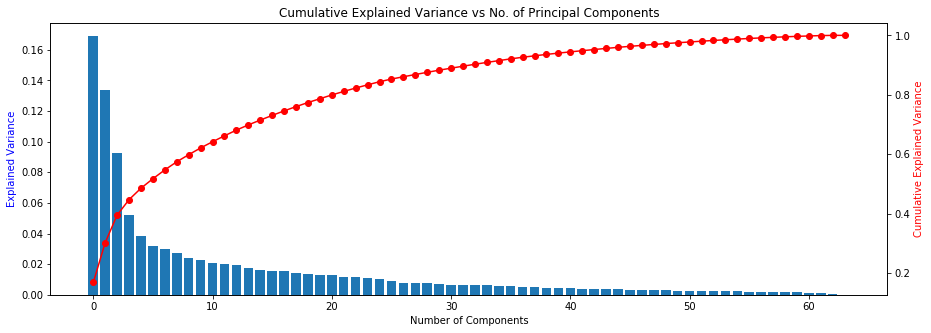

In [50]:
# Investigate the variance accounted for by each principal component.
# refer to this blog:https://github.com/S-Tabor/udacity-customer-segmentation-project/blob/master/identify_customer_segments_final.ipynb
components_total = len(pca.explained_variance_ratio_)
components = np.arange(components_total)

fig, ax1 = plt.subplots(figsize=(15,5))

ax1.bar(components,pca.explained_variance_ratio_)
ax1.set_ylabel('Explained Variance', color="blue")
ax1.set_xlabel('Number of Components')

ax2 = ax1.twinx() 
ax2.plot(np.cumsum(pca.explained_variance_ratio_), color="red",marker='o')
ax2.set_ylabel('Cumulative Explained Variance', color="red")
plt.title("Cumulative Explained Variance vs No. of Principal Components")


In [51]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_26 = PCA(n_components=26)
dem_pca_26 = pca_26.fit_transform(dem_scale)
dem_pca_26_df = pd.DataFrame(dem_pca_26)


In [52]:
np.cumsum(pca.explained_variance_ratio_[:10])[-1]

0.62139365731246221

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

I use PCA method on the scaled dataset and plot explained variance against the number of components together with cumulative explained variance. I choose to keep 26 components to acheive a higher model accuracy. And I discover that the first ten components give a cum variance of 62%.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [53]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

# check general weights condition
weights = pd.DataFrame(np.round(pca_26.components_, 4), columns = dem_scale.columns)
print(weights.shape)
weights.head()

(26, 64)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,-0.1175,0.0057,-0.2193,0.1436,-0.1105,0.0650,0.0734,0.1645,-0.1083,0.0283,...,0.2178,0.0419,-0.1672,0.1441,0.1970,0.1353,0.0997,-0.1068,0.2078,-0.1236
1,0.2604,0.0864,0.0719,-0.2418,0.2337,-0.2121,-0.2312,0.1161,-0.0134,-0.0581,...,0.0861,0.0130,-0.0694,0.0652,0.0882,0.0630,-0.2515,-0.0113,0.0709,0.0028
2,0.0765,-0.3727,0.1599,-0.1035,0.0975,-0.1905,-0.0951,-0.0495,0.0501,-0.0151,...,0.0432,0.0052,-0.0358,0.0323,0.0462,0.0305,-0.1049,0.0493,0.0237,-0.0079
3,-0.0435,0.0403,0.0639,-0.0002,-0.0163,-0.1265,0.0906,-0.1095,0.3894,0.0054,...,0.0795,0.1483,0.0426,0.0463,0.2498,0.0939,0.0399,0.3876,-0.1281,0.0596
4,0.0054,0.0079,0.0860,-0.0064,-0.0647,0.0360,-0.0460,-0.0978,0.0636,0.0130,...,0.0316,-0.4701,-0.3933,0.2176,0.0950,0.1407,0.0284,0.0613,-0.0117,0.0211


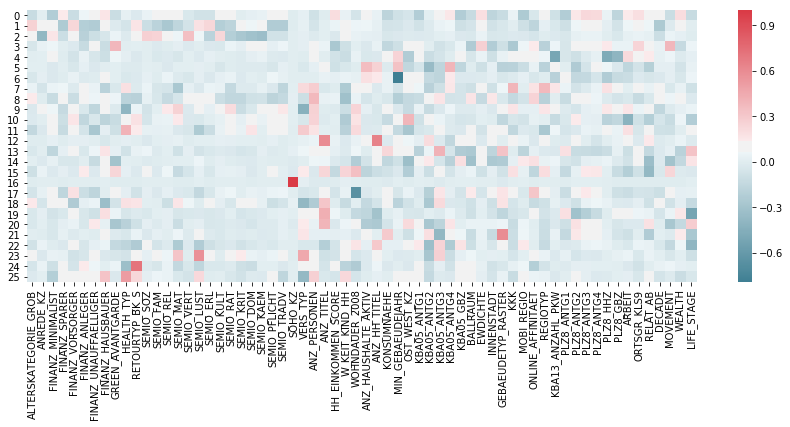

In [54]:
# check general weights condition
f, ax = plt.subplots(figsize=(15, 5))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(weights,cmap=cmap)

In [55]:
def get_com_weight_on_features(pca,dem_scale,com_num):
    """
    return all weight of the com_num-th component
    """
    weights = pd.DataFrame(np.round(pca_26.components_, 4), columns = dem_scale.columns)
    weight_n = weights.iloc[com_num - 1, :].sort_values()
    weight_n = weight_n.to_frame()
    weight_n.reset_index(level=0, inplace=True)
    weight_n.columns = ['colname','weight']
    return weight_n


In [56]:
def get_top_N_features(com_weight,n):
    """
    return top/down N features weight
    """
    tail_n = com_weight.head(5).reset_index(drop=True)
    head_n = com_weight.tail(5).sort_values(by='weight',ascending=False).reset_index(drop=True)
    top_n = pd.concat([head_n, tail_n], axis=1)
    top_n.columns = ['top_pos_col','top_pos_col_weight','top_neg_col','top_neg_col_weight']
    return top_n

In [57]:
com_weight = get_com_weight_on_features(pca_26,dem_scale,1)
com_weight.describe()
top_features = get_top_N_features(com_weight,10)
top_features.style.bar(align='mid')

,top_pos_col,top_pos_col_weight,top_neg_col,top_neg_col_weight
0,PLZ8_ANTG3,0.2264,MOBI_REGIO,-0.2425
1,PLZ8_ANTG4,0.2178,PLZ8_ANTG1,-0.2245
2,HH_EINKOMMEN_SCORE,0.2082,KBA05_ANTG1,-0.223
3,WEALTH,0.2078,FINANZ_MINIMALIST,-0.2193
4,ORTSGR_KLS9,0.197,KBA05_GBZ,-0.2183


In [ ]:
Top 5 Positive

PLZ8_ANTG3: Number of 6-10 family houses in the PLZ8 region (0: no 6-10 family homes, 3: high share of 6-10 family homes)
PLZ8_ANTG4 : Number of 10+ family houses in the PLZ8 region (0: no 10+ family home, 2: high share of 10+ family homes)
HH_EINKOMMEN_SCORE: Estimated household net income (1: highest income, 6: very low income)
WEALTH: Household wealth - Engineered (1: Wealthy Households, 5: Poorer Households)
ORTSGR_KLS9: Size of community (1: <= 2,000 inhabitants, 9: > 700,000 inhabitants)
# people live in high share community with low income 

Top 5 Negative
MOBI_REGIO : Movement patterns (1: very high movement, 6: none)
PLZ8_ANTG1: Number of 1-2 family houses in the PLZ8 region (0: no 1-2 family homes, 4: very high share of 1-2 family homes)
KBA05_ANTG1 : Number of 1-2 family houses in the microcell (0: no 1-2 family homes, 4: very high share of 1-2 family homes)
FINANZ_MINIMALIST : Financial typology - MINIMALIST: low financial interest (1: very high, 5: very low)
KBA05_GBZ: Number of buildings in the microcell(1: 1-2 buildings;5: >=23 buildings)
# people live in less dense region with higher financial ability

So the first component captures the population density and financial condition

In [58]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
com_weight = get_com_weight_on_features(pca_26,dem_scale,2)
com_weight.describe()
top_features = get_top_N_features(com_weight,10)
top_features.style.bar(align='mid')


,top_pos_col,top_pos_col_weight,top_neg_col,top_neg_col_weight
0,ALTERSKATEGORIE_GROB,0.2604,SEMIO_REL,-0.2609
1,FINANZ_VORSORGER,0.2337,DECADE,-0.2515
2,SEMIO_ERL,0.2297,FINANZ_SPARER,-0.2418
3,SEMIO_LUST,0.1812,FINANZ_UNAUFFAELLIGER,-0.2312
4,RETOURTYP_BK_S,0.1681,SEMIO_TRADV,-0.2276


In [ ]:
Top 5 Positive:
ALTERSKATEGORIE_GROB: Estimated age based on given name analysis (1: < 30 years old, 4: > 60 years old, 9: uniformly distributed)
FINANZ_VORSORGER: Financial typology - Be prepared (1: Very high, 5: Very low)
SEMIO_ERL: Personality typology - event-oriented ( 1: highest affinity, 7: lowest affinity)
SEMIO_LUST: Personality typology - sensual-minded ( 1: highest affinity, 7: lowest affinity)
RETOURTYP_BK_S: Return type (1: influenceable Crazy-Shopper, 5: determined Minimal-Returner)
# people who are older, less prepared in financial,low affinity,determined Minimal-Returner
    
Top 5 Negative
SEMIO_REL: Personality typology - religious ( 1: highest affinity, 7: lowest affinity)
DECADE: Person’s decade of youth (1: 40s , 6: 90s)
FINANZ_SPARER: Financial typology - money-saver (1: Very high, 5: Very low)
FINANZ_UNAUFFAELLIGER: Financial typology - inconspicuous (1: Very high, 5: Very low)
SEMIO_TRADV: Personality typology - tradional-minded ( 1: highest affinity, 7: lowest affinity)

# So the second component seems to indicate age,personality


In [59]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
com_weight = get_com_weight_on_features(pca_26,dem_scale,3)
com_weight.describe()
top_features = get_top_N_features(com_weight,10)
top_features.style.bar(align='mid')


,top_pos_col,top_pos_col_weight,top_neg_col,top_neg_col_weight
0,SEMIO_VERT,0.3524,ANREDE_KZ,-0.3727
1,SEMIO_SOZ,0.2664,SEMIO_KAEM,-0.3332
2,SEMIO_FAM,0.2529,SEMIO_DOM,-0.3087
3,SEMIO_KULT,0.2354,SEMIO_KRIT,-0.2713
4,FINANZ_MINIMALIST,0.1599,SEMIO_RAT,-0.2119


In [ ]:
Top 5 Positive:
SEMIO_VERT: Personality typology - VERT: dreamful (1: highest affinity, 7: lowest affinity)
SEMIO_SOZ: Personality typology - SOZ: socially-minded (1: highest affinity, 7: lowest affinity)
SEMIO_FAM: Personality typology - family-minded ( 1: highest affinity, 7: lowest affinity)
SEMIO_KULT: Personality typology - cultural-minded ( 1: highest affinity, 7: lowest affinity)
FINANZ_MINIMALIST : Financial typology - MINIMALIST: low financial interest (1: very high, 5: very low)

Top 5 Negative
ANREDE_KZ: Gender ( 1: male, 2: female)
SEMIO_KAEM: Personality typology - KAEM: combative attitude ( 1: highest affinity, 7: lowest affinity)
SEMIO_DOM: Personality typology - DOM: dominant-minded ( 1: highest affinity, 7: lowest affinity)
SEMIO_KRIT: Personality typology - KRIT: critical-minded ( 1: highest affinity, 7: lowest affinity)
SEMIO_RAT: Personality typology - RAT: rational ( 1: highest affinity, 7: lowest affinity)

# So The third component seems to indicate gender,personality

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

1. So the first component captures the population density and financial condition
Top 5 Positive

PLZ8_ANTG3: Number of 6-10 family houses in the PLZ8 region (0: no 6-10 family homes, 3: high share of 6-10 family homes)
PLZ8_ANTG4 : Number of 10+ family houses in the PLZ8 region (0: no 10+ family home, 2: high share of 10+ family homes)
HH_EINKOMMEN_SCORE: Estimated household net income (1: highest income, 6: very low income)
WEALTH: Household wealth - Engineered (1: Wealthy Households, 5: Poorer Households)
ORTSGR_KLS9: Size of community (1: <= 2,000 inhabitants, 9: > 700,000 inhabitants)
#people live in high share community with low income 

Top 5 Negative
MOBI_REGIO : Movement patterns (1: very high movement, 6: none)
PLZ8_ANTG1: Number of 1-2 family houses in the PLZ8 region (0: no 1-2 family homes, 4: very high share of 1-2 family homes)
KBA05_ANTG1 : Number of 1-2 family houses in the microcell (0: no 1-2 family homes, 4: very high share of 1-2 family homes)
FINANZ_MINIMALIST : Financial typology - MINIMALIST: low financial interest (1: very high, 5: very low)
KBA05_GBZ: Number of buildings in the microcell(1: 1-2 buildings;5: >=23 buildings)
#people live in less dense region with higher financial ability

2. So the second component seems to indicate age,personality
Top 5 Positive:
ALTERSKATEGORIE_GROB: Estimated age based on given name analysis (1: < 30 years old, 4: > 60 years old, 9: uniformly distributed)
FINANZ_VORSORGER: Financial typology - Be prepared (1: Very high, 5: Very low)
SEMIO_ERL: Personality typology - event-oriented ( 1: highest affinity, 7: lowest affinity)
SEMIO_LUST: Personality typology - sensual-minded ( 1: highest affinity, 7: lowest affinity)
RETOURTYP_BK_S: Return type (1: influenceable Crazy-Shopper, 5: determined Minimal-Returner)
#people who are older, less prepared in financial,low affinity,determined Minimal-Returner
    
Top 5 Negative
SEMIO_REL: Personality typology - religious ( 1: highest affinity, 7: lowest affinity)
DECADE: Person’s decade of youth (1: 40s , 6: 90s)
FINANZ_SPARER: Financial typology - money-saver (1: Very high, 5: Very low)
FINANZ_UNAUFFAELLIGER: Financial typology - inconspicuous (1: Very high, 5: Very low)
SEMIO_TRADV: Personality typology - tradional-minded ( 1: highest affinity, 7: lowest affinity)

3. So The third component seems to indicate gender,personality
Top 5 Positive:
SEMIO_VERT: Personality typology - VERT: dreamful (1: highest affinity, 7: lowest affinity)
SEMIO_SOZ: Personality typology - SOZ: socially-minded (1: highest affinity, 7: lowest affinity)
SEMIO_FAM: Personality typology - family-minded ( 1: highest affinity, 7: lowest affinity)
SEMIO_KULT: Personality typology - cultural-minded ( 1: highest affinity, 7: lowest affinity)
FINANZ_MINIMALIST : Financial typology - MINIMALIST: low financial interest (1: very high, 5: very low)

Top 5 Negative
ANREDE_KZ: Gender ( 1: male, 2: female)
SEMIO_KAEM: Personality typology - KAEM: combative attitude ( 1: highest affinity, 7: lowest affinity)
SEMIO_DOM: Personality typology - DOM: dominant-minded ( 1: highest affinity, 7: lowest affinity)
SEMIO_KRIT: Personality typology - KRIT: critical-minded ( 1: highest affinity, 7: lowest affinity)
SEMIO_RAT: Personality typology - RAT: rational ( 1: highest affinity, 7: lowest affinity)


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [87]:
# Over a number of different cluster counts...

# run k-means clustering on the data and...
    
# compute the average within-cluster distances.
 
max_cluster = 20  
scores = {}
for i in range(2, max_cluster):
    # run k-means clustering on the data and...
    print(i)
    scores[i] = np.abs(KMeans(n_clusters=i).fit(dem_pca_26).score(dem_pca_26))


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


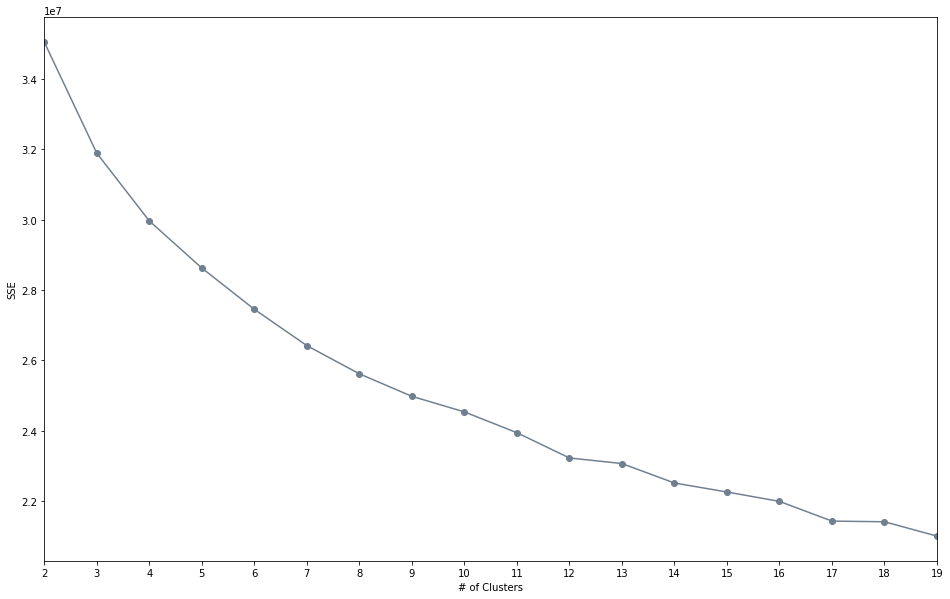

In [89]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
# Plot relationship plot
fig, ax = plt.subplots(figsize=(16,10))    
ax = pd.Series(scores).plot(marker='o', color='slategray')
ax.set_xticks(np.arange(2, max_cluster), minor=False);
ax.set_xlabel("# of Clusters")
ax.set_ylabel("SSE");

In [62]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans_model = KMeans(n_clusters=10, n_jobs=-1, random_state=0).fit(dem_pca_26)
dem_pca_26_df["labels"] = kmeans_model.labels_

In [63]:
print(kmeans_model.labels_)
print(dem_pca_26_df.head())

[3 1 0 ..., 1 2 8]
          0         1         2         3         4         5         6  \
0  3.907813 -2.656815 -2.895801 -0.431174 -2.502602  2.186966  0.663503   
1 -0.893352  0.179040 -3.051476  2.232254 -0.914788 -0.246077  0.301159   
2 -4.068325  1.143320 -0.822066 -0.918259  0.781444  0.890020 -1.684059   
3  0.571166  0.223032  3.234550  0.628176  1.396090 -2.795826 -0.616124   
4 -0.710984 -1.353124 -1.047913 -1.814107 -3.407436 -1.052930  0.452265   

          7         8         9   ...          17        18        19  \
0  0.903875  1.286838 -0.613856   ...   -0.321565 -0.955371  1.278683   
1 -0.987770  0.880517 -1.282910   ...   -1.352460  1.024069 -0.228548   
2 -0.518068 -1.375962 -0.237681   ...    0.008097  0.385037 -0.469851   
3  2.317031  1.317533 -0.632995   ...   -0.502070 -0.334184 -0.296646   
4 -0.619557 -2.743609  1.535071   ...    1.116145 -2.371417  0.006345   

         20        21        22        23        24        25  labels  
0  1.136489 -0.2150

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

I have tested with a range of the number of clusters from 2 to 19 and plot SSE against cluster number. And from the plot we can see there is a shift in the rate at which SSE decreases in the range of 6 to 10 clusters. So I decide to use 9 clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [64]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';') 
print(customers.shape)

(191652, 85)


In [65]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
cus_df, cust_highna_df = clean_data(customers,missing_data_encode,cols_remove,feat_info)


process done missing code to nan
process done remove high missing rate colunms and rows
process done re-encode and engineer


In [66]:
# check data clean 
assert(cus_df.shape[1] == dem_df.shape[1])
print(cus_df.columns == dem_df.columns)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


In [67]:
# Impute
cus_imp = imp.transform(cus_df)
# Scale
cus_scale = scaler.transform(cus_imp)
cus_scale = pd.DataFrame(cus_scale, columns=cus_df.columns)
cus_scale.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
count,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,...,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000
mean,0.688522,-0.363980,0.891955,-0.860591,0.813680,-0.816789,-0.539144,-0.302508,0.643515,-0.308751,...,-0.242311,0.019533,0.240965,-0.375556,-0.119608,-0.156540,-0.994144,0.646734,-0.499256,0.333220
std,0.700623,0.940133,0.746176,0.555839,0.597206,0.684123,0.691450,0.958598,1.179776,1.011043,...,0.870094,0.968659,0.904228,1.016882,0.938308,1.049384,0.919622,1.177238,0.965707,0.893255
min,-1.746287,-1.022678,-1.512226,-1.141397,-1.765054,-1.221852,-1.139026,-1.588887,-0.553672,-1.591635,...,-0.981973,-2.721004,-2.111170,-2.223015,-1.914219,-1.563993,-2.280170,-0.553672,-1.595951,-1.251111
25%,0.202108,-1.022678,0.692400,-1.141397,0.394972,-1.221852,-1.139026,-0.856544,-0.553672,-1.591635,...,-0.981973,-0.639701,-0.314765,-1.212095,-0.607437,-0.823841,-1.591245,-0.553672,-1.595951,-0.584134
50%,1.176305,-1.022678,1.427276,-1.141397,1.114980,-1.221852,-0.410325,-0.856544,1.806125,-0.273495,...,-0.981973,-0.002344,0.583438,-0.201175,-0.171843,-0.083688,-0.902320,1.806125,-0.909992,0.749820
75%,1.176305,0.977825,1.427276,-0.460783,1.114980,-0.531624,-0.410325,0.608142,1.806125,1.044646,...,0.384671,0.400951,0.583438,0.809745,0.699344,0.656464,-0.213395,1.806125,0.461926,0.749820
max,1.176305,0.977825,1.427276,1.581061,1.114980,1.539061,1.775776,1.340485,1.806125,1.044646,...,1.751315,1.441603,1.481641,1.820665,1.570532,1.396616,1.164455,1.806125,1.147884,1.416797


In [68]:
# Dimensionality reduction
cus_pca = pca_26.transform(cus_scale)
cus_pca_df = pd.DataFrame(cus_pca)
print(cus_pca.shape)

(133427, 26)


In [69]:
# Clustering
cus_kmeans = kmeans_model.predict(cus_pca)
cus_pca_df["labels"] = cus_kmeans
print(np.unique(cus_kmeans))

[0 1 2 3 4 5 6 7 8 9]


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [70]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
pop_freq = pd.DataFrame(itemfreq(dem_pca_26_df["labels"]),columns=['label','freq'])
pop_freq['group'] = 'pop'
pop_freq['freq'] = pop_freq['freq']/pop_freq['freq'].sum()
#print(pop_freq)

# proportion of data in each cluster for the customer population.
cus_freq = pd.DataFrame(itemfreq(cus_pca_df["labels"]),columns=['label','freq'])
cus_freq['group'] = 'cus'
cus_freq['freq'] = cus_freq['freq']/cus_freq['freq'].sum()
#print(cus_freq)

# combine two data frame
total_freq = pop_freq.append(cus_freq)
print(total_freq )

   label      freq group
0      0  0.107783   pop
1      1  0.101084   pop
2      2  0.086819   pop
3      3  0.102215   pop
4      4  0.122137   pop
5      5  0.130915   pop
6      6  0.033876   pop
7      7  0.127166   pop
8      8  0.108240   pop
9      9  0.079763   pop
0      0  0.086459   cus
1      1  0.014727   cus
2      2  0.009713   cus
3      3  0.010125   cus
4      4  0.415261   cus
5      5  0.099725   cus
6      6  0.032025   cus
7      7  0.117532   cus
8      8  0.192450   cus
9      9  0.021982   cus


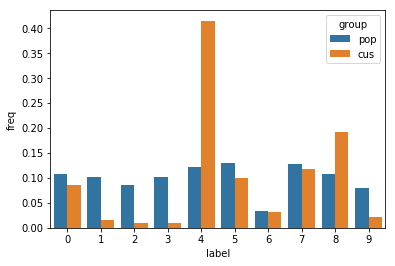

In [71]:
# make a visual plot
ax=sns.barplot(x='label', y='freq', hue='group', data=total_freq)

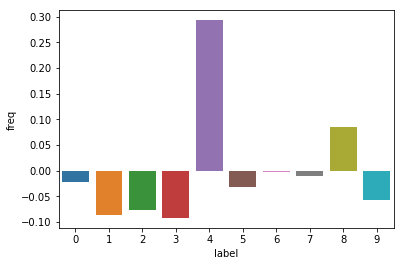

In [72]:
# make a visual plot about customer freq - population freq
ax=sns.barplot(x=cus_freq.label, y=cus_freq.freq - pop_freq.freq)

In [84]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
# cluster 4 is overrepresented
def map_kmeans_weights_to_feats(kmeans, df, clust_no):
    '''Map pca weights to  individual features
    and return two pd.Series on with the highest
    positive weights and one with the lowest negative
    weights'''

    weights = pd.DataFrame(np.round(kmeans.cluster_centers_, 4), columns=df.keys())
    centroid = weights.iloc[clust_no, :]
    cent_pos = centroid[centroid > 0].sort_values(ascending=False).to_frame()
    cent_pos.reset_index(level=0, inplace=True)
    cent_pos.columns = ['top_pos_col','top_pos_col_weight']
    cent_neg = centroid[centroid < 0].sort_values(ascending=True).to_frame()
    cent_neg.reset_index(level=0, inplace=True)
    cent_neg.columns = ['top_neg_col','top_neg_col_weight']
    top_pca_feature = pd.concat([cent_pos, cent_neg], axis=1)
    top_pca_feature['top_neg_col'] = top_pca_feature['top_neg_col'].apply(str)
    top_pca_feature['top_pos_col'] = top_pca_feature['top_pos_col'].apply(str)
    return top_pca_feature



In [85]:
# Overrepresented are cluster 4 by barplot
top_pca_feature = map_kmeans_weights_to_feats(kmeans_model, cus_pca_df.iloc[:, :-1], 4)
top_pca_feature.style.bar(align='mid')
#top_pca_feature.style.apply(highlight_cols, axis=None)
# component 1,4,2 have the greatest impact

,top_pos_col,top_pos_col_weight,top_neg_col,top_neg_col_weight
0,3,2.5617,0,-3.5215
1,1,0.9727,14,-0.4256
2,2,0.6457,10,-0.3403
3,15,0.3688,20,-0.3333
4,6,0.2634,22,-0.1531
5,4,0.2583,5,-0.1034
6,17,0.2366,12,-0.0644
7,8,0.0972,25,-0.0433
8,9,0.0934,11,-0.0391
9,19,0.0572,13,-0.0238


In [86]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
# cluster 3 are most underrepresented
top_pca_feature = map_kmeans_weights_to_feats(kmeans_model, cus_pca_df.iloc[:, :-1], 3)
top_pca_feature.style.bar(align='mid')
# component 1,3,2 have the greatest impact

,top_pos_col,top_pos_col_weight,top_neg_col,top_neg_col_weight
0,0,4.4577,2.0,-2.6027
1,9,0.4822,1.0,-1.1801
2,3,0.3607,7.0,-0.2658
3,17,0.1586,8.0,-0.17
4,10,0.1264,18.0,-0.0893
5,15,0.1162,24.0,-0.0846
6,23,0.1126,25.0,-0.0652
7,6,0.1118,5.0,-0.0606
8,4,0.0812,14.0,-0.0557
9,22,0.0731,11.0,-0.0412


### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

1. popular segements
First component has the greatest negative influence,which means that someone that ,is low movement(MOBI_REGIO) ,live in less dense area(PLZ8_ANTG3,PLZ8_ANTG4) with a lot small family houses(PLZ8_ANTG1,KBA05_ANTG1),in good finanical conditions are target users.

1. unpopular segements
First component has the greatest positive influence which means the opposite feature mentioned in popular segements are unpopular segements.The Third component has the greatest negative effect,which means people who are female, very dreamful are less likely to be target customer.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.